In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer as Tfidf
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
#read datasets in
amazon = pd.read_csv("./datasets/amazon_sample.csv")
andromeda = pd.read_csv("./datasets/andromeda_posts.csv")

In [5]:
#check their size
print "Shape of clearweb set:", amazon.shape, " Shape of dark web set:", andromeda.shape

Shape of clearweb set: (20000, 2)  Shape of dark web set: (19009, 3)


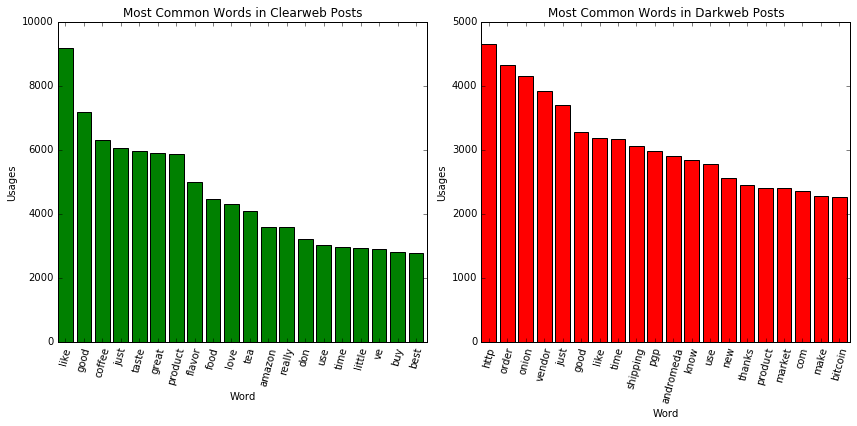

In [7]:
def freq_plt(axis, title, freq, tok_size, color): #generates bar graphs as per schema above
    
    x_lab = np.arange(20)
    words, incidences = zip(*freq[:20])
    incidences = np.array(incidences)
    
    axis.bar(x_lab, incidences, color=color)
    axis.set_xticks(x_lab+.4)
    axis.set_xticklabels(words)
    axis.set_title(title)
    axis.set_xlabel("Word")
    #axis.set_ylim(0,0.25)
    axis.set_ylabel("Usages")

#vectorize clearweb tweets

vectorizer = CountVectorizer(stop_words='english') #ignores stop words such as "a," "the," etc.

c_revs = amazon['content'].values #clearweb tweets
d_revs = andromeda['content'].values #darkweb tweets

c_tokens = vectorizer.fit_transform([unicode(a, errors='replace') for a in c_revs]) #tokenize and get words by frequency
c_freq = sorted(zip(vectorizer.get_feature_names(), np.array(c_tokens.sum(axis=0)).ravel()), key=lambda x: -x[1])[1:]

d_tokens = vectorizer.fit_transform([unicode(str(a), errors='replace') for a in d_revs]) #tokenize and get words by frequency
d_freq = sorted(zip(vectorizer.get_feature_names(), np.array(d_tokens.sum(axis=0)).ravel()), key=lambda x: -x[1])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

freq_plt(ax[0], "Most Common Words in Clearweb Posts", c_freq, c_tokens.shape[0], "green")
freq_plt(ax[1], "Most Common Words in Darkweb Posts", d_freq, d_tokens.shape[0], "red")


for ax in fig.axes: #plot most common words
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=75)
    
plt.tight_layout()

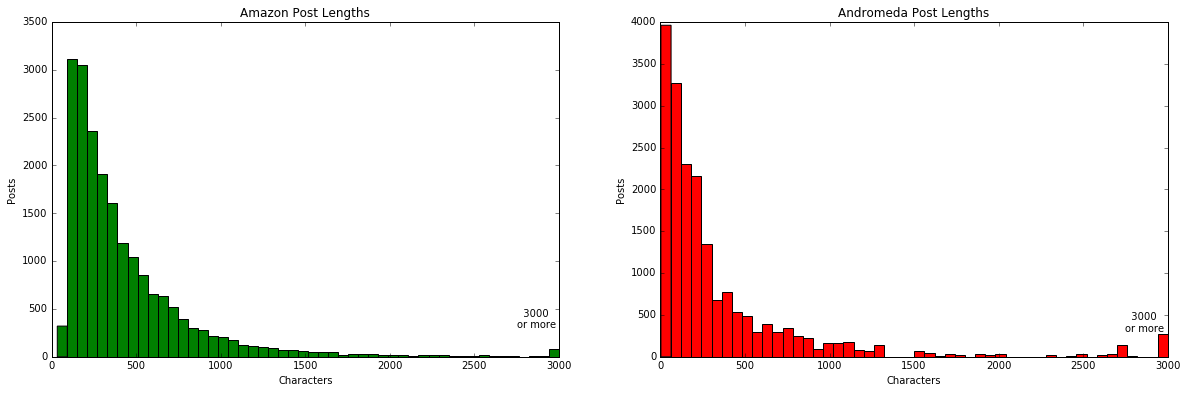

In [11]:
c_lens = [] #clearweb tweet lengths
d_lens = [] #darkweb tweet lengths

for post in amazon['content'].values:
    length = len(str(post).strip())
    if length <= 3000:
        c_lens.append(length)
    else:
        c_lens.append(3000)
        
for post in andromeda['content'].values:
    length = len(str(post).strip())
    if length <= 3000:
        d_lens.append(length)
    else:
        d_lens.append(3000)
        
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].hist(c_lens, bins=50, color='green')
ax[0].set_xlim(0, 3000)
ax[0].set_title('Amazon Post Lengths')
ax[0].set_xlabel("Characters")
ax[0].set_ylabel("Posts")
ax[0].annotate("  3000\nor more", (2750,300))


ax[1].hist(d_lens, bins=50, color='red')
ax[1].set_xlim(0, 3000)
ax[1].set_title('Andromeda Post Lengths')
ax[1].set_xlabel("Characters")
ax[1].set_ylabel("Posts")
ax[1].annotate("  3000\nor more", (2750,300))


plt.show()

In [46]:
long_posts = []
for post in andromeda['content'].values:
    length = len(str(post).strip())
    if length >= 3000:
        long_posts.append(post)

        
pgp_uses = 0

for post in andromeda['content'].values:
    if 'BEGIN PGP SIGNED MESSAGE' in str(post):
        pgp_uses += 1
        
print pgp_uses, "Andromeda posts use PGP SHA1 signatures. That is", "{}% of all posts".format(round(pgp_uses/float(andromeda.shape[0])*100, 3))

pgp_uses = 0

for post in long_posts:
    if 'BEGIN PGP SIGNED MESSAGE' in str(post):
        pgp_uses += 1
        
print pgp_uses, "of the {} 3000+ character Andromeda posts use PGP SHA1 signatures. That is".format(len(long_posts)), "{}% of all long posts".format(round(pgp_uses/float(len(long_posts))*100, 3))

pgp_uses = 0

for post in amazon['content'].values:
    if 'BEGIN PGP SIGNED MESSAGE' in str(post):
        pgp_uses += 1

print
print pgp_uses, "Amazon posts use PGP SHA1 signatures. That is", "{}% of all posts".format(round(pgp_uses/float(andromeda.shape[0])*100, 3))


105 Andromeda posts use PGP SHA1 signatures. That is 0.552% of all posts
29 of the 241 3000+ character Andromeda posts use PGP SHA1 signatures. That is 12.033% of all long posts

0 Amazon posts use PGP SHA1 signatures. That is 0.0% of all posts


In [48]:
dark_words = dict(d_freq)
clear_words = dict(c_freq)

expletives = pd.read_csv("./datasets/profanity.csv", header=None)[0].tolist()

#deepweb expletives
dwe = 0
for x in expletives:
    try:
        dwe += dark_words[x]
    except KeyError:
        continue

#clearweb expletives
cwe = 0
for x in expletives:
    try:
        cwe += clear_words[x]
    except KeyError:
        continue
        
print "About {}% of words in dark web marketplaces are profanity".format((dwe / float(d_tokens.size))*100)
print "About {}% of words in Amazon reviews are profanity".format((cwe / float(c_tokens.size))*100)

About 0.279090502119% of words in dark web marketplaces are profanity
About 0.0282513395032% of words in Amazon reviews are profanity


In [109]:
c_set = set([x[0].encode('ascii') for x in c_freq[:1000]])
d_set = set([x[0].encode('ascii') for x in d_freq[:1000]])

c_not_d = c_set - d_set #words in positive top 1000 not in negative top 1000
d_not_c = d_set - c_set #words in negative top 1000 not in negative top 1000

print "\nWords in Deepweb top 1000 not in Clearweb top 1000:\n", len(d_not_c)


Words in Deepweb top 1000 not in Clearweb top 1000:
614


In [110]:
print list(d_not_c)[:100]

c_set = set([x[0].encode('ascii') for x in c_freq[:100]])
d_set = set([x[0].encode('ascii') for x in d_freq[:100]])

c_not_d = c_set - d_set #words in positive top 1000 not in negative top 1000
d_not_c = d_set - c_set #words in negative top 1000 not in negative top 1000

['limited', 'code', 'forget', 'caused', 'follow', 'andro', 'integrity', 'tt', 'flash', 'send', 'answered', 'charge', 'program', 'xtc', 'encrypted', 'backopy', 'include', 'friendly', 'road', 'updated', 'risk', 'mg', 'sellers', 'updates', 'anonymous', 'ticket', 'button', 'posts', 'upload', 'javascript', 'team', 'imgur', 'guy', 'setup', 'prevent', 'mail', 'sign', '____', 'likely', 'pass', 'link', 'click', 'index', 'wondering', 'current', 'waiting', 'international', 'net', 'public', 'hasn', 'friday', 'hash', 'darknet', 'protection', 'euro', 'address', 'active', 'appears', 'sending', 'search', '38', 'forum', 'receive', 'mdma', 'funded', 'pics', '28gs', 'smoke', 'que', 'options', 'secure', 'private', 'county', 'fake', 'cocaine', 'forums', 'select', 'everybody', 'usd', 'crap', 'figure', 'working', 'prove', 'positive', 'coins', 'blockchain', 'trusted', 'hydra', 'doubt', 'passport', 'taken', 'markets', 'blueberry', 'posting', 'ti', 'envelope', 'confused', 'tested', 'vpn', 'topic']


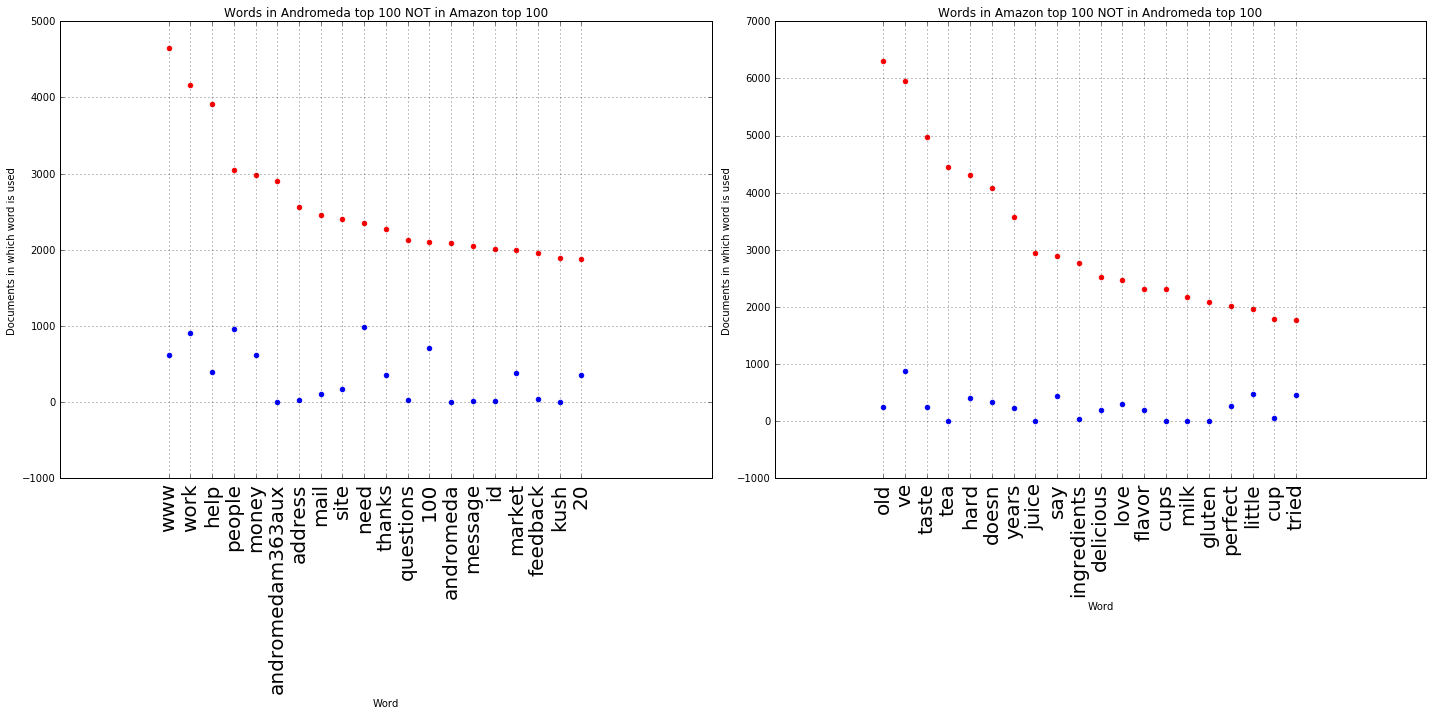

In [120]:
pw_usage_d = [x for x in d_freq if x[0] in d_not_c] #positive top 100 word frequencies in positive reviews
pw_usage_c = []

for word in d_not_c:
    if word in clear_words:
        pw_usage_c.append(clear_words[word])
    else:
        pw_usage_c.append(0)
        
        
nw_usage_c = [x for x in c_freq if x[0] in c_not_d] #positive top 100 word frequencies in positive reviews
nw_usage_d = []

for word in c_not_d:
    if word in dark_words:
        nw_usage_d.append(dark_words[word])
    else:
        nw_usage_d.append(0)
        
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
x_lab = np.arange(20)

pw_usage_d = pw_usage_d[:20]
pw_usage_c = pw_usage_c[:20]
nw_usage_c = nw_usage_c[:20]
nw_usage_d = nw_usage_d[:20]


#Positive top 100 frequencies in Positive and Negative Reviews
ax[0].scatter(range(len(pw_usage_c)), pw_usage_c, color='blue', label="Clear") #scatter neg words
ax[0].scatter(range(len(pw_usage_c)), [x[1] for x in pw_usage_d], color='red', label="Dark") #scatter pos words
ax[0].set_title("Words in Andromeda top 100 NOT in Amazon top 100")
ax[0].set_xlabel("Word")
ax[0].set_ylabel("Documents in which word is used")
ax[0].set_xticks(x_lab)
ax[0].set_xticklabels(list(d_not_c)[:20])

ax[1].scatter(range(len(nw_usage_c)), [x[1] for x in nw_usage_c], color='red')
ax[1].scatter(range(len(nw_usage_c)), nw_usage_d, color='blue')
ax[1].set_title("Words in Amazon top 100 NOT in Andromeda top 100")
ax[1].set_xlabel("Word")
ax[1].set_ylabel("Documents in which word is used")
ax[1].set_xticks(x_lab)
ax[1].set_xticklabels(list(c_not_d)[:20])


for ax in fig.axes: #adjust labels on x axis
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90, fontsize=20)
    plt.grid()

plt.legend()

plt.tight_layout()

In [125]:
c_set = set([x[0].encode('ascii') for x in c_freq[:1000]])
d_set = set([x[0].encode('ascii') for x in d_freq[:1000]])

c_not_d = c_set - d_set #words in positive top 1000 not in negative top 1000
d_not_c = d_set - c_set #words in negative top 1000 not in negative top 1000

hyperpolarized = []

for word in d_not_c:
    if word in clear_words:
        if clear_words[word] > 5:
            continue
        else: hyperpolarized.append(word)

print hyperpolarized

['integrity', 'flash', 'updates', 'anonymous', 'upload', '____', 'hash', 'euro', 'pics', 'county', 'forums', 'usd', 'ti', 'topic', 'locked', 'wallet', 'scam', 'customs', 'fe', 'sr', 'le', '2014', 'shatter', 'evolution', 'netherlands', '2c', 'turtle', 'en', 'eu', 'meth', 'dispatched', 'heroin', '___', 'blister', 'faucet', 'thread', 'messages', '10mg', 'mining', 'uncut', 'marijuana', 'invite', 'worldwide', 'clearer', 'services', 'payment', 'potency', 'aaaa', 'tps', 'skunk', 'layout', 'gmail', '01', '04', '05', '08', 'stamps', 'korea', 'legit', 'admin', 'und', 'login', 'cc', 'capable', 'commission', 'ecstasy', 'keys', 'weed', 'cloudberry', 'php', 'client', 'victim', 'addresses', 'postal', 'format', 'amp', 'server', 'payments', 'security', 'tracked', 'provider', 'trustworthy', 'funds', 'registered', 'announcement', 'delete', 'file', 'shit', 'acetaminophen', 'log']


In [135]:
for word in ['integrity', 'anonymous', 'hash', 'euro', 'scam', 
             'netherlands', 'marijuana', 'legit', 'ecstasy', 'cloudberry',
             'victim', 'security', 'tracked', 'trustworthy', 'log']:
    print word, ":"
    print "Andromeda Uses:", dark_words[word]
    print "Amazon Uses:   ", clear_words[word]
    print

integrity :
Andromeda Uses: 146
Amazon Uses:    5

anonymous :
Andromeda Uses: 140
Amazon Uses:    2

hash :
Andromeda Uses: 205
Amazon Uses:    4

euro :
Andromeda Uses: 241
Amazon Uses:    4

scam :
Andromeda Uses: 687
Amazon Uses:    1

netherlands :
Andromeda Uses: 232
Amazon Uses:    1

marijuana :
Andromeda Uses: 313
Amazon Uses:    2

legit :
Andromeda Uses: 198
Amazon Uses:    1

ecstasy :
Andromeda Uses: 191
Amazon Uses:    1

cloudberry :
Andromeda Uses: 135
Amazon Uses:    4

victim :
Andromeda Uses: 132
Amazon Uses:    2

security :
Andromeda Uses: 674
Amazon Uses:    4

tracked :
Andromeda Uses: 252
Amazon Uses:    2

trustworthy :
Andromeda Uses: 274
Amazon Uses:    4

log :
Andromeda Uses: 240
Amazon Uses:    5



In [137]:
import os
os.environ['PATH']

'/opt/local/bin:/opt/local/sbin:/Users/JohnBowers/anaconda/bin:/Library/Frameworks/Python.framework/Versions/3.5/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin'